# **5.4 Linear_Regression**

 예측값과 실제 값의 RSS을 최소화 하는 OLS 추정방식으로 구현한 클래스  

 ##### **파라미터**
 
- fit_intercept : 절편값을 계산할 것인가?
- normalize : 절편값을 계산할 때, 회귀를 수행하기 전에 입력 데이터 세트를 정규화 한다.
(linear_model은 스케일에 영향을 많이 받는다.)  
그렇지만 여기서 하는것 보다는 minmax로 먼저 하는것이 좋다

##### **선형 회귀의 다중 공선성 문제**

선형 회귀는 입력 피처의 독립성에 영향을 받는다. 피처간 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 취약하다. 이러한 현상을 다중 공선성 (multi-collinearity) 문제라고 한다. 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용한다.  
예, 방의 크기와 면적은 상관성이 높아서 성능이 떨어질 수 있다. 일단 해보고 판단하자

##### **회귀 평가 지표**

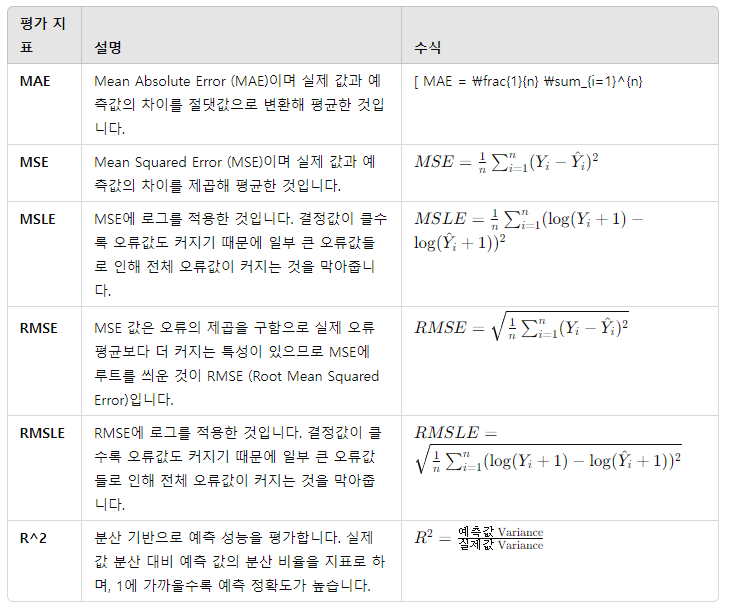

RMSE는 MAE에 비해 큰 오류값에 더 큰 페널티를 부여한다. 제곱이 들어가기 때문.

사이킷런 Scoring 함수(cross_val_score, GrisSearchCV)에 회귀 평가 적용시 유의 사항

- 정확도, f1, auc는 모두 크면 좋지만 오류는 낮아야 좋기 때문에 -1을 곱해준다  
작은 숫자를 크게 인식하도록 바꾼다.

### **Boston Housing Dataset**

In [1]:
import sklearn
print(sklearn.__version__)

1.1.3


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston

%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
print(boston)
print(type(boston))
print(boston.data)
print(type(boston.data))
print(boston.feature_names)

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]]), 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 1

- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)

- 각 컬럼이 주택가격에 미치는 영향도를 조사

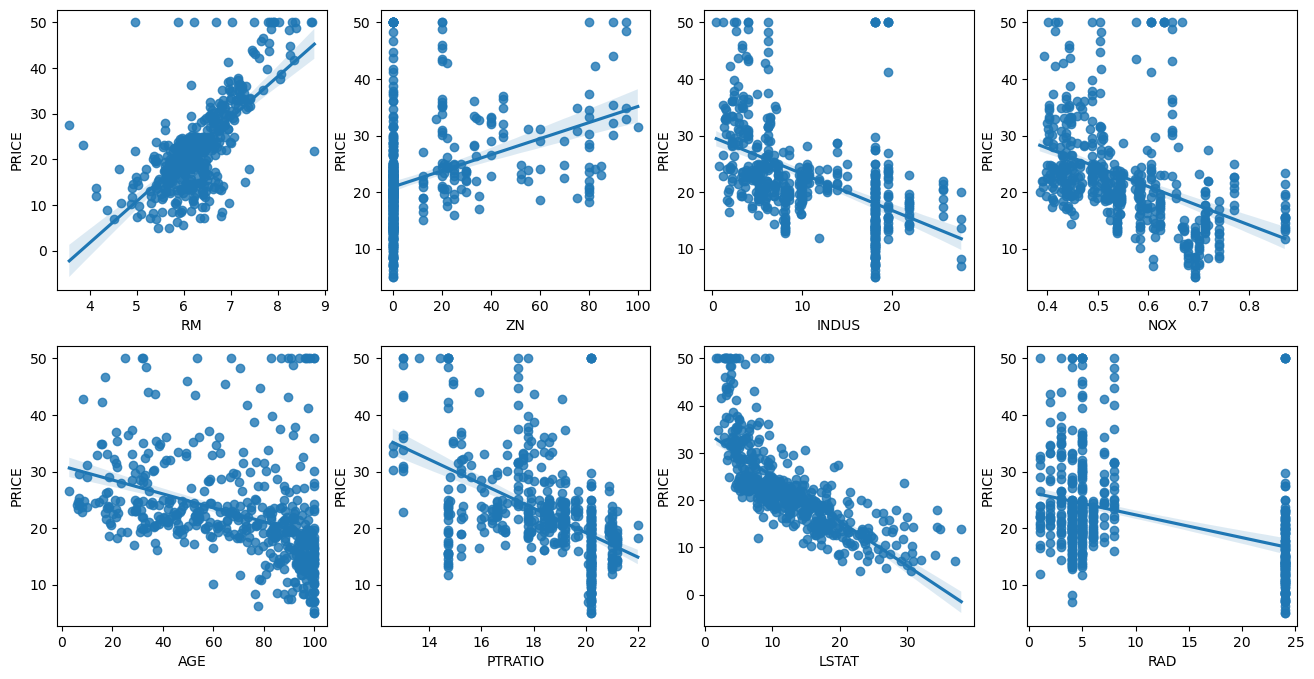

In [8]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    # 개별적인 이치에 접근하기 위한 계산하기 위한 계산
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

fig1 = plt.gcf()
fig1.savefig('p322_boston.tif', format='tif', dpi=300, bbox_inches='tight')

### **Train / Test split, Train, Predict, Evaluate**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train) # fit을 하는순간 회귀 계수가 저장된다. (coef_) 
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
# squared = False라고하면 rmse가 출력된다.
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


회귀에서는 라벨이 연속적인 값이라 평가를 정확도로 하기는 어려워 보인다.

In [10]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216412
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [11]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

NOX가 매우크다. 회귀계수가 혼자서 너무 크면 오버피팅할 가능성이 높다 

In [12]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores) # 다시 마이너스
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 
